In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("/usr/local/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [2]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("../data/sim") # Set this to your data path
prefix = "rf2"

number_neurons = 4096
number_stimuli = 6
time_range = 1800
bin_size = 100e-3

In [3]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtimes = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),number_stimuli))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtimes[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=number_neurons)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...


In [4]:
# Constants
response_start = int(2 / bin_size)
response_end = int(2.5 / bin_size)
spike_threshold = 15 * (response_end - response_start) * bin_size  # 15Hz

stim_start_times = stimtimes[1::4]
stims = np.array([np.where(stim)[0][0] for stim in stimdata[1::4]]) 

# Function to get the associated time bin for the given float time. Ex: for t = 0.5, returns 50
def get_time_bin(t):
    return int(t / bin_size)

# Identify relevant time bins for each stimulus
response_bins = [
    np.array(range(
        get_time_bin(t) + response_start,
        min(get_time_bin(t) + response_end, get_time_bin(time_range)-1)
    ), dtype=int)
    for t in stim_start_times
]

stimulus_time_bins_list = [[] for _ in range(number_stimuli)]

for stim, bins in zip(stims, response_bins):
    stimulus_time_bins_list[stim].extend(bins)

# Determine which neurons respond to each stimulus
responding_neurons = []

for bins in stimulus_time_bins_list:
    # Sum up the spikes for each neuron in the identified bins
    spike_counts = np.sum(data[bins], axis=0)
    frequency = spike_counts / (len(bins) * bin_size)
    
    # Neurons that respond have spike rates > 15Hz during the 2-2.5s after stimulus onset
    responding = np.where(frequency > spike_threshold)[0]
    responding_neurons.append(responding)

for i, neurons in enumerate(responding_neurons):
    print(f"Stimulus {i} has {len(neurons)} responding neurons")

Stimulus 0 has 989 responding neurons
Stimulus 1 has 982 responding neurons
Stimulus 2 has 679 responding neurons
Stimulus 3 has 822 responding neurons
Stimulus 4 has 628 responding neurons
Stimulus 5 has 760 responding neurons


In [93]:
stim = 4
t_begin = 1500
t_end = 1800
t_begin_bin = int(t_begin // bin_size)
t_end_bin = int(t_end // bin_size)

single_stim_data = data[:,responding_neurons[stim]]
single_stim_data = single_stim_data[t_begin_bin:t_end_bin]

spikes_stim = np.where(stims == stim, 1, 0)

time_mask = (stim_start_times > t_begin) & (stim_start_times < t_end)
spikes_stim = spikes_stim[time_mask]
selected_times = stim_start_times[time_mask]

y = np.sum(single_stim_data, axis=1)

Plotting ...


/tmp/ipykernel_3609/2988132183.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(selected_times, spikes_stim, basefmt="r", linefmt="r", markerfmt=" ", use_line_collection=True)


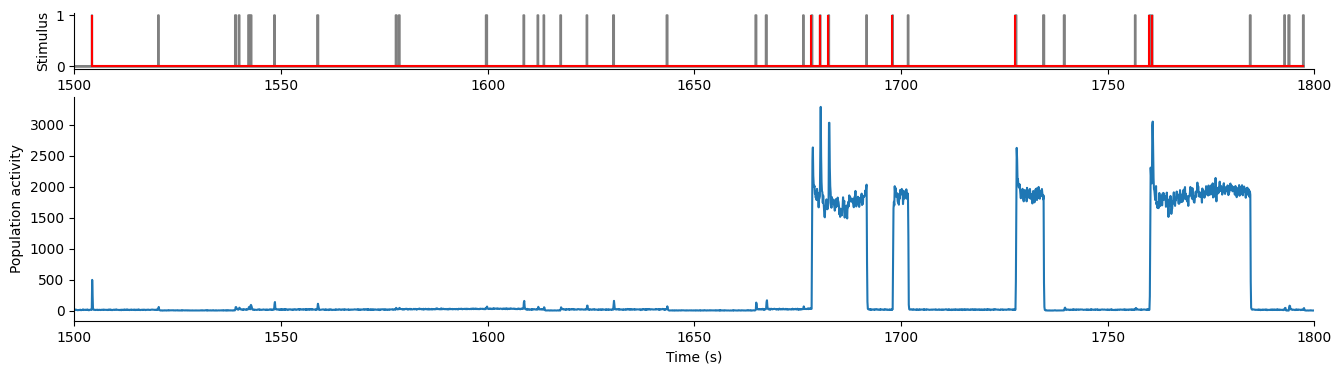

In [94]:
print("Plotting ...")
time = np.linspace(t_begin, t_end, len(y))
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(16,4))

ax = plt.subplot(gs[0])
plt.plot(stimtimes, stimdata, color="gray")
plt.stem(selected_times, spikes_stim, basefmt="r", linefmt="r", markerfmt=" ", use_line_collection=True)
plt.xlim((t_begin,t_end))
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
sns.despine()

ax = plt.subplot(gs[1])
plt.plot(time, y)
plt.xlim((t_begin,t_end))
plt.xlabel("Time (s)")
plt.ylabel("Population activity")
sns.despine()

In [66]:
spikes_stim
selected_times


array([1504.211 , 1520.258 , 1538.8599, 1539.7748, 1542.052 , 1542.5116,
       1548.3313, 1558.7308, 1577.7354, 1578.4822, 1599.5462, 1608.6377,
       1612.0437, 1613.5029, 1617.5549, 1623.9158, 1630.3235, 1643.2715,
       1664.7688, 1667.2721, 1676.2995, 1678.2943, 1680.343 , 1682.3997,
       1691.5764, 1697.8956, 1701.6219, 1727.5978, 1734.3656, 1739.3731,
       1756.5693, 1760.02  , 1760.6221, 1784.3794, 1792.7089, 1793.6984,
       1797.2285])

In [ ]:
# I have a numpy array time_binned_spike_counts of shape (18000, 4096) that corresponds to 18000 time bins (each with 100ms) of 4096 neurons' activity, the value being the number of spikes of each neuron in each time bin.

# I also have an array stimtime of shape (2338,) that corresponds to all the times one of 4 stimuli was shown to the network. There is also an array stimdata of shape (2338, 4), where at each stimtime there is a binary array of length 4 representing which stimulus if any is being shown represented by theh stimulus' index having the value of 1.

# Write the python code to determine what neurons respond to each of the 4 stimuli. A neuron responds to a stimulus if between 2 seconds and 2.5 seconds after a given stimulus is shown, the frequency of this neuron spiking is higher than 10HzI have a numpy array time_binned_spike_counts of shape (18000, 4096) that corresponds to 18000 time bins (each with 100ms) of 4096 neurons' activity, the value being the number of spikes of each neuron in each time bin.

# I also have an array stimtime of shape (2338,) that corresponds to all the times one of 4 stimuli was shown to the network. There is also an array stimdata of shape (2338, 4), where at each stimtime there is a binary array of length 4 representing which stimulus if any is being shown represented by theh stimulus' index having the value of 1.

# Write the python code to determine what neurons respond to each of the 4 stimuli. A neuron responds to a stimulus if between 2
# seconds and 2.5 seconds after a given stimulus is shown, the frequency of this neuron spiking is higher than 10Hz